Comparing the different choices for the polynomials that are used for the recursion constructing the Trefftz basis. In 1+1 dimensions on a mesh with anisotropic elements.

In [1]:
N = 3
c=3
t_steps = c*N
order = 12
k = 1

In [2]:
import netgen.meshing as ngm
from netgen.geom2d import unit_square
from ngsolve import *

ngmesh = ngm.Mesh()
ngmesh.SetGeometry(unit_square)
ngmesh.dim = 2
pnums = []
for i in range(t_steps + 1):
    for j in range(N + 1):
        pnums.append(ngmesh.Add(ngm.MeshPoint(ngm.Pnt(i / t_steps, j / N, 0))))

foo = ngm.FaceDescriptor(surfnr=1,domin=1,bc=1)
ngmesh.Add (foo)
ngmesh.SetMaterial(1, "mat")
for j in range(t_steps):
    for i in range(N):
        ngmesh.Add(ngm.Element2D(1, [pnums[i + j * (N + 1)],
                                 pnums[i + (j + 1) * (N + 1)],
                                 pnums[i + 1 + (j + 1) * (N + 1)],
                                 pnums[i + 1 + j * (N + 1)]]))
for i in range(t_steps):
   ngmesh.Add(ngm.Element1D([pnums[N + i * (N + 1)], pnums[N + (i + 1) * (N + 1)]], index=1))
   ngmesh.Add(ngm.Element1D([pnums[0 + i * (N + 1)], pnums[0 + (i + 1) * (N + 1)]], index=1))
for i in range(N):
   ngmesh.Add(ngm.Element1D([pnums[i], pnums[i + 1]], index=2))
   ngmesh.Add(ngm.Element1D([pnums[i + t_steps * (N + 1)], pnums[i + 1 + t_steps * (N + 1)]], index=2))

mesh = Mesh(ngmesh)
Draw(mesh)
# print("boundaries" + str(mesh.GetBoundaries()))

In [3]:
from ngsolve import *
from trefftzngs import *
import numpy as np
# fes = L2(mesh, order=order, flags = { "dgjumps" : True })

truesol =  sin( k*(c*x + y) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*x+y))#grad(U0)[0]
sig0 = -k*cos(k*(c*x+y))#-grad(U0)[1]
# U0 = GridFunction(fes)
# U0.Set(truesol)
# Draw(U0,mesh,'U0')

In [4]:
def MakeSystem(truesol,v0,sig0,fes):
    U = fes.TrialFunction()
    V = fes.TestFunction()

    v = grad(U)[0]
    sig = -grad(U)[1]
    w = grad(V)[0]
    tau = -grad(V)[1]

    vo = grad(U.Other())[0]
    sigo = -grad(U.Other())[1]
    wo = grad(V.Other())[0]
    tauo = -grad(V.Other())[1]

    h = specialcf.mesh_size
    n = specialcf.normal(2)
    n_t = n[0]/Norm(n)
    n_x = n[1]/Norm(n)

    mean_v = 0.5*(v+vo)
    mean_w = 0.5*(w+wo)
    mean_sig = 0.5*(sig+sigo)
    mean_tau = 0.5*(tau+tauo)

    jump_vx = ( v - vo ) * n_x
    jump_wx = ( w - wo ) * n_x
    jump_sigx = ( sig - sigo ) * n_x
    jump_taux = ( tau - tauo ) * n_x

    jump_vt = ( v - vo ) * n_t
    jump_wt = ( w - wo ) * n_t
    jump_sigt = ( sig - sigo ) * n_t
    jump_taut = ( tau - tauo ) * n_t

    jump_Ut = (U - U.Other()) * n_t
    #gfu.vec.data = a.mat.Inverse() * f.vec

    timelike = n_x**2 #IfPos(n_t,0,IfPos(-n_t,0,1)) # n_t=0
    spacelike = n_t**2 #IfPos(n_x,0,IfPos(-n_x,0,1)) # n_x=0

    alpha = 0.5 #pow(10,5)
    beta = 0.5 #pow(10,5)
    gamma = 1

    a = BilinearForm(fes)
    # a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt+jump_taux) + IfPos(n_t,sig,sigo)*(jump_wx+jump_taut) ) ,VOL,  skeleton=True ) #space like faces
    a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt) + IfPos(n_t,sig,sigo)*(jump_taut) ) ,VOL,  skeleton=True ) #space like faces, no jump in x since horizontal
    a += SymbolicBFI( timelike 	* ( mean_v*jump_taux + mean_sig*jump_wx + alpha*jump_vx*jump_wx + beta*jump_sigx*jump_taux ) ,VOL, skeleton=True ) #time like faces
    a += SymbolicBFI( spacelike * IfPos(n_t,1,0) * ( pow(c,-2)*v*w + sig*tau ), BND, skeleton=True) #t=T (or *x)
    a += SymbolicBFI( timelike 	* ( sig*n_x*w + alpha*v*w ), BND, skeleton=True) #dirichlet boundary 'timelike'
    a += SymbolicBFI( spacelike * ( gamma * (jump_Ut)*IfPos(n_t,V.Other(),V) ) ,VOL,  skeleton=True ) #correction term to recover sol of second order system
    a += SymbolicBFI( spacelike * ( gamma * IfPos(-n_t,1,0) * U*V ) ,BND,  skeleton=True ) #BND correction term to recover sol of second order system
    a.Assemble()

    f = LinearForm(fes)
    f += SymbolicLFI( spacelike * IfPos(-n_t,1,0) *  ( pow(c,-2)*v0*w + sig0*tau ), BND, skeleton=True) #t=0 (or *(1-x))
    f += SymbolicLFI( timelike 	* ( v0 * (alpha*w - tau*n_x) ), BND, skeleton=True) #dirichlet boundary 'timelike'
    f += SymbolicLFI( spacelike * gamma * IfPos(-n_t,1,0) *  ( (truesol)*V ) ,BND,  skeleton=True ) #rhs correction term to recover sol of second order system
    f.Assemble()

    return [a,f]
    # gfu2= GridFunction(fes, name="uDG")
    # gfu2.vec.data = a.mat.Inverse() * f.vec

In [5]:
def SolveNp(a,f,fes):
	gfu = GridFunction(fes, name="uDG")

	nmat = np.zeros((a.mat.height,a.mat.width))
	nvec = np.zeros(a.mat.width)

	for i in range(a.mat.width):#gfu.vec.data = a.mat.Inverse() * f.vec
		for j in range(a.mat.height):
			nmat[j,i] = a.mat[j,i]
	nvec = f.vec.FV().NumPy() #nvec

	sol = np.linalg.solve(nmat,nvec)
	for i in range(a.mat.height):
		gfu.vec[i] = sol[i]
	# print("cond nmat: ", np.linalg.cond(nmat))
	return [gfu,np.linalg.cond(nmat)]

In [6]:
def error(gfu,truesol,fes):
	U0 = GridFunction(fes)
	U0.Set(truesol)
	L2error = Integrate((truesol - gfu)*(truesol - gfu), mesh)
	sH1error = Integrate((grad(U0) - grad(gfu))*(grad(U0) - grad(gfu)), mesh)
	# print("error=", L2error)
	# print("grad-error=", sH1error)
	#Draw(gfu,mesh,'sol')
	#Draw(grad(gfu),mesh,'gradsol')
	return [L2error,sH1error]

In [7]:
solution = []
for order in range(3,13):
    for btype in range(0,3):
        print("run order nr.: " + str(order))
        fes = FESpace("trefftzfespace", mesh, order = order, wavespeed = c, dgjumps=True, basistype = btype)
        [a,f] = MakeSystem(truesol,v0,sig0,fes)
        [gfu,cond] = SolveNp(a,f,fes)
        [L2error,sH1error] = error(gfu,truesol,fes)
        solution.append([btype,order,cond,L2error,sH1error])
        print("btype: " + str(btype) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

run order nr.: 3
btype: 0 cond: 2681.41519078 L2error: 6.892011164393294e-09 H1error: 1.3188709075898215e-06
run order nr.: 3
btype: 1 cond: 41051.9584053 L2error: 6.892011180641904e-09 H1error: 1.3188709076056468e-06
run order nr.: 3
btype: 2 cond: 224826.457317 L2error: 6.892011114101554e-09 H1error: 1.318870907617195e-06
run order nr.: 4
btype: 0 cond: 7805.5599143 L2error: 5.880910955229197e-12 H1error: 4.4670381557917046e-09
run order nr.: 4
btype: 1 cond: 468657.333524 L2error: 5.8809111140859505e-12 H1error: 4.467038139644415e-09
run order nr.: 4
btype: 2 cond: 1929899.83093 L2error: 5.880917784977713e-12 H1error: 4.467038148018113e-09
run order nr.: 5
btype: 0 cond: 20015.9609321 L2error: 3.3476222493614547e-15 H1error: 9.759892425459958e-12
run order nr.: 5
btype: 1 cond: 324306462.168 L2error: 3.345927774499816e-15 H1error: 9.759635287969377e-12
run order nr.: 5
btype: 2 cond: 250072379.162 L2error: 3.3501928939375207e-15 H1error: 9.759995296319839e-12
run order nr.: 6
btype:

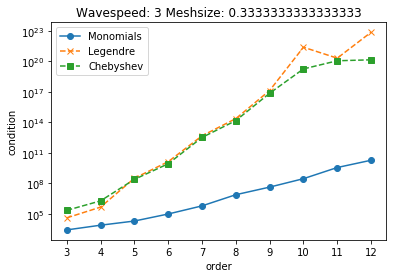

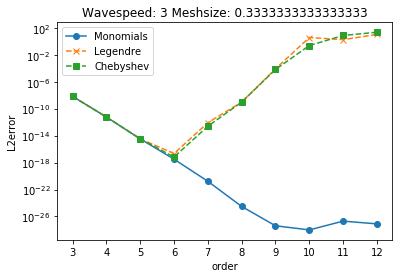

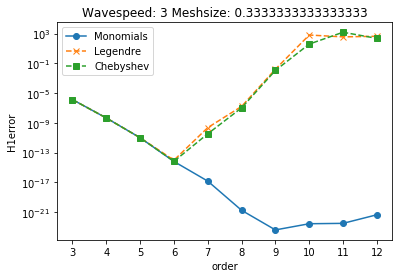

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

data = ['condition', 'L2error', 'H1error']
sol = np.array(solution)

for i in range(len(data)):
    fig = plt.figure()
    ax = fig.gca()
    plt.semilogy(sol[sol[:,0]==0,1], sol[sol[:,0]==0,i+2], '-o', label="Monomials")
    plt.semilogy(sol[sol[:,0]==1,1], sol[sol[:,0]==1,i+2], '--x', label="Legendre")
    plt.semilogy(sol[sol[:,0]==2,1], sol[sol[:,0]==2,i+2], '--s', label="Chebyshev")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
    plt.legend()
    plt.ylabel(data[i])
    plt.xlabel('order')
    plt.savefig("results/diffbasis_"+data[i]+".png")
    plt.show()